# Tiny ImageNet

Tiny ImageNet is a smaller subset of the ImageNet dataset designed for quick prototyping and experimentation. It is widely used in deep learning research and education due to its manageable size and complexity.

## Key Features
- **Number of Classes**: 200 classes, each corresponding to a specific object category.
- **Image Size**: All images are resized to 64x64 pixels, making it computationally efficient to train models.
- **Dataset Structure**:
  - **Training Set**: 100,000 images (500 per class).
  - **Validation Set**: 10,000 images (50 per class).
  - **Test Set**: 10,000 images (unlabeled).


## Dataset Organization
Tiny ImageNet is organized into folders:
- `train/`: Contains subfolders for each class with images for training.
- `val/`: Contains validation images and a CSV file `val_annotations.txt` with image-label mappings.
- `test/`: Contains test images (no labels provided).


https://www.kaggle.com/c/tiny-imagenet

In [1]:
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow.keras.backend as K
import itertools
from functools import partial

from tensorflow.keras import mixed_precision
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

In [2]:
mixed_precision.set_global_policy('mixed_float16')

Your GPU may run slowly with dtype policy mixed_float16 because it does not have compute capability of at least 7.0. Your GPU:
  NVIDIA GeForce GTX 1050, compute capability 6.1
See https://developer.nvidia.com/cuda-gpus for a list of GPUs and their compute capabilities.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once


In [3]:
RANDOM_SEED = 42
IMG_HEIGHT = 64
IMG_WIDTH = 64
BATCH_SIZE = 32

In [4]:
physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))

if physical_devices:
    print(f"TensorFlow is using GPU: {physical_devices[0].name}")
else:
    print("No GPU found. TensorFlow is running on the CPU.")

Num GPUs Available:  1
TensorFlow is using GPU: /physical_device:GPU:0


Download files from https://www.kaggle.com/datasets/akash2sharma/tiny-imagenet

In [5]:
default_path = "tiny-imagenet-200"
path_to_train_files = default_path + "/train"  # kaggle: "../input/tiny-imagenet/tiny-imagenet-200/train"
path_to_val_files = default_path + "/val/images" # kaggle: "../input/tiny-imagenet/tiny-imagenet-200/val/images"
path_to_test_files = default_path + "/test/images" # kaggle: "../input/tiny-imagenet/tiny-imagenet-200/test/images"

In [6]:
unique_tiny_labels = os.listdir(path_to_train_files)

In [7]:
unique_labels = pd.read_csv(default_path + "/words.txt", sep='\t', 
                header=None, names=["class_id", "label"])
unique_labels.class_id = unique_labels.class_id.astype(str)
unique_labels = unique_labels.loc[unique_labels['class_id'].isin(unique_tiny_labels)]
unique_labels.sort_values(by="label", inplace=True)
unique_labels.reset_index(inplace=True, drop=True)
unique_labels = tf.convert_to_tensor(unique_labels)

In [8]:
train_files_pattern = os.path.join(path_to_train_files, '*', 'images', '*.JPEG')
train_ds_files = tf.data.Dataset.list_files(train_files_pattern, shuffle=True, seed=RANDOM_SEED)

In [9]:
val_files_pattern = os.path.join(path_to_val_files, '*.JPEG')
test_files_pattern = os.path.join(path_to_test_files, '*.JPEG')

val_ds_files = tf.data.Dataset.list_files(val_files_pattern)
test_ds = tf.data.Dataset.list_files(test_files_pattern)

In [10]:
val_labels = pd.read_csv(default_path + "/val/val_annotations.txt",  sep='\t', 
                header=None, names=["file_name", "class_id", "box_coord_1", "box_coord_2", "box_coord_3", "box_coord_4"])

In [11]:
val_labels = tf.convert_to_tensor(val_labels[["file_name", "class_id"]])

In [12]:
@tf.function
def load_image(filename, is_train_ds=True):
    image = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
        
    parts = tf.strings.split(filename, os.sep)

    if is_train_ds:
        label = parts[-3]  
    else:
        file_basename = parts[-1]  
        label = val_labels[tf.argmax(tf.equal(val_labels[:, 0], file_basename)), 1]
        
    #label = unique_labels[tf.argmax(tf.equal(unique_labels[:, 0], label)), 1] # if string label
    label = tf.argmax(tf.equal(unique_labels[:, 0], label)) # if as int
    
    return image, label

In [13]:
@tf.function
def apply_data_augmentation(image, label, scale_mode='0_1',  augmentation_type=None):

    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)

    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    image = tf.image.random_saturation(image, lower=0.8, upper=1.2)
    image = tf.image.random_hue(image, max_delta=0.1)
    
    if augmentation_type == 'randaugment':
        k = tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32)
        image = tf.image.rot90(image, k=k)
        
        max_shift = 4
        image = tf.image.resize_with_crop_or_pad(image, IMG_HEIGHT + max_shift, IMG_WIDTH + max_shift)
        image = tf.image.random_crop(image, size=[IMG_HEIGHT, IMG_WIDTH, 3])

    if scale_mode == '0_1':
        image = tf.cast(image, tf.float16)
        image = tf.clip_by_value(image, 0.0, 1.0)
    else:
        image = tf.clip_by_value(image * 255, 0, 255)
        image = tf.round(image)
        image = tf.cast(image, tf.uint8)

    return image, label

In [14]:
def configure_performance(ds, is_train_ds=True, scale_mode="0_1", augmentation_type=None):
    if is_train_ds:
        ds = ds.cache()
        ds = ds.shuffle(10000)
        ds = ds.map(lambda img, label: apply_data_augmentation(img, label, scale_mode=scale_mode, augmentation_type=augmentation_type), 
                    num_parallel_calls=tf.data.AUTOTUNE)
        ds = ds.batch(BATCH_SIZE)
        ds = ds.prefetch(tf.data.AUTOTUNE)
    else:
        ds = ds.cache()
        ds = ds.batch(BATCH_SIZE)
        ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

In [15]:
train_ds = configure_performance(train_ds_files.map(lambda fname: load_image(fname),num_parallel_calls=tf.data.experimental.AUTOTUNE), is_train_ds=True, scale_mode="0_1", augmentation_type=None)
val_ds = configure_performance(val_ds_files.map(lambda fname: load_image(fname, is_train_ds=False), num_parallel_calls=tf.data.experimental.AUTOTUNE), is_train_ds=False)

train_ds_unscld = configure_performance(train_ds_files.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE),  is_train_ds=True, scale_mode="0_255", augmentation_type=None)
val_ds_unscld = configure_performance(val_ds_files.map(lambda fname: load_image(fname, is_train_ds=False), num_parallel_calls=tf.data.experimental.AUTOTUNE), is_train_ds=False)

In [16]:
image_batch, labels_batch = next(iter(train_ds))

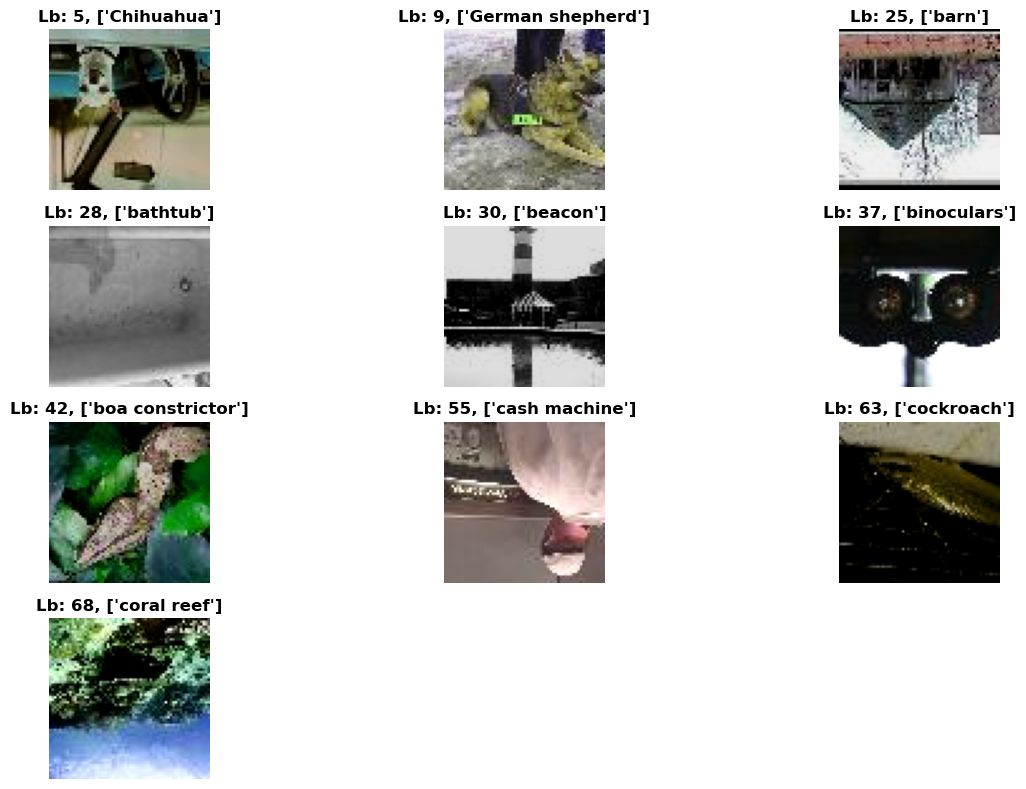

In [17]:
plt.figure(figsize=(12, 8))

for idx, label in enumerate(np.unique(labels_batch.numpy().astype(int).tolist())[:10]):
  ax = plt.subplot(4, 3, idx + 1)
  label_idx = tf.argmax(labels_batch.numpy() == label).numpy()
  plt.imshow(tf.cast(image_batch[label_idx], tf.float32))
  plt.title(f"Lb: {label}, {unique_labels[label].numpy()[1].decode('utf-8').split(',')[0:1]}", fontweight="bold")
  plt.axis("off")

plt.tight_layout()
plt.show()

## Using a State-of-Art CNN Architecture

ConvNext V1:
https://arxiv.org/pdf/2201.03545

In [18]:
class StochasticDepth(tf.keras.layers.Layer):
    """ Aka Drop Path """
    def __init__(self, drop_path, **kwargs):
        super(StochasticDepth, self).__init__(**kwargs)
        self.drop_path = drop_path

    def call(self, x, training=None):
        if training:
            keep_prob = 1 - self.drop_path
            shape = (tf.shape(x)[0],) + (1,) * (len(tf.shape(x)) - 1)
            random_tensor = keep_prob + tf.random.uniform(shape, 0, 1)
            random_tensor = tf.floor(random_tensor)
            return (x / tf.cast(keep_prob, tf.float16)) * tf.cast(random_tensor, tf.float16)
        return x

### Drop Path example

In [19]:
random_pic = next(iter(train_ds))
sample_img, sample_label = random_pic[0][0], random_pic[1][0]

In [20]:
drop_path = 0.3
keep_prob = 1 - drop_path
shape = (tf.shape(sample_img)[0],) + (1,) * (len(tf.shape(sample_img)) - 1)
random_tensor = keep_prob + tf.random.uniform(shape, 0, 1)
random_tensor = tf.floor(random_tensor)

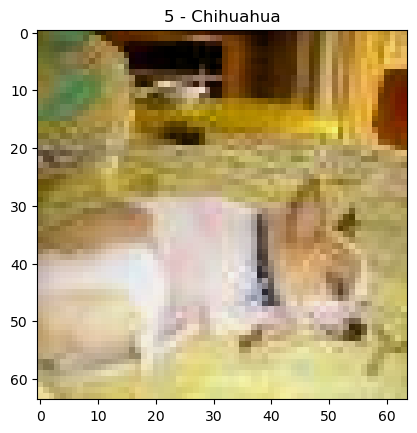

In [21]:
plt.imshow(tf.cast(sample_img, tf.float32))
plt.title(f"{sample_label} - {unique_labels[int(sample_label.numpy())][1].numpy().decode('utf-8')}")
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.3623047].


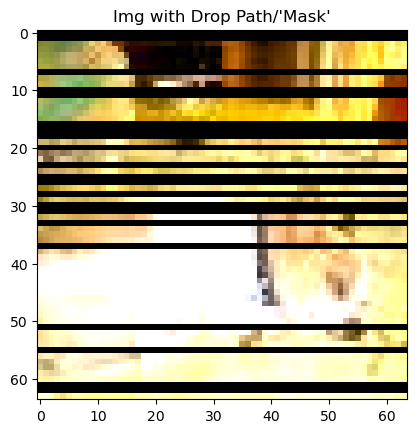

In [22]:
plt.imshow((tf.cast(sample_img, tf.float32) / keep_prob) * random_tensor)
plt.title("Img with Drop Path/'Mask'")
plt.show()

In [23]:
class Block(tf.keras.Model):
    """ConvNeXt block.

    References:
        (1) https://arxiv.org/pdf/2201.03545
        (2) https://github.com/facebookresearch/ConvNeXt/blob/main/models/convnext.py
        (3) https://github.com/sayakpaul/ConvNeXt-TF/blob/main/models/convnext_tf.py
    """

    def __init__(self, dim, drop_path=0.0, layer_scale_init_value=1e-6, **kwargs):
        super(Block, self).__init__(**kwargs)
        self.dim = dim
        if layer_scale_init_value > 0:
            self.gamma = tf.Variable(layer_scale_init_value * tf.ones((dim,), tf.float16))
        else:
            self.gamma = None
        self.dw_conv_1 = tf.keras.layers.Conv2D( 
            filters=dim, kernel_size=7, padding="same", groups=dim ## depthwise conv
        )
        # Groups: A positive int specifying the number of groups in which the input is split along the channel axis. 
        # Each group is convolved separately with filters // groups filters. The output is the concatenation of all the groups results along the channel axis. 
        # Input channels and filters must both be divisible by groups.

        self.layer_norm = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.pw_conv_1 = tf.keras.layers.Dense(4 * dim) # pointwise/1x1 convs, implemented with linear layers
        self.act_fn = tf.keras.layers.Activation("gelu") 
        self.pw_conv_2 = tf.keras.layers.Dense(dim)
        self.drop_path = (
            StochasticDepth(drop_path)
            if drop_path > 0.0
            else tf.keras.layers.Activation("linear")
        )

    def call(self, inputs):
        x = inputs

        x = self.dw_conv_1(x)
        x = self.layer_norm(x)
        x = self.pw_conv_1(x)
        x = self.act_fn(x)
        x = self.pw_conv_2(x)

        if self.gamma is not None:
            x = self.gamma * x

        return inputs + self.drop_path(x) # Residual Connection


In [24]:
def return_convnext_model(
    model_name="convnext_tiny",
    input_shape=(224, 224, 3),
    num_classes=200,
    depths=[3, 3, 27, 3],
    dims=[128, 256, 512, 1024],
    drop_path_rate=0.0,
    layer_scale_init_value=1e-6,
    ) -> tf.keras.Model:
    
    """Implements ConvNeXt Base given configurations. convnext_base_1k_224

    References:
        (1) https://arxiv.org/abs/2201.03545
        (2) https://github.com/facebookresearch/ConvNeXt/blob/main/models/convnext.py
        (3) https://github.com/sayakpaul/ConvNeXt-TF/blob/main/models/convnext_tf.py
    """

    inputs = tf.keras.layers.Input(input_shape)
    stem = tf.keras.Sequential(
        [
            tf.keras.layers.Conv2D(dims[0], kernel_size=4, strides=4),
            tf.keras.layers.LayerNormalization(epsilon=1e-6),
        ],
        name="stem",
    )

    downsample_layers = []
    downsample_layers.append(stem)
    for i in range(3):
        downsample_layer = tf.keras.Sequential(
            [
                tf.keras.layers.LayerNormalization(epsilon=1e-6),
                tf.keras.layers.Conv2D(dims[i + 1], kernel_size=2, strides=2),
            ],
            name=f"downsampling_block_{i}",
        )
        downsample_layers.append(downsample_layer)

    stages = []  # 4 feature resolution stages, each consisting of multiple residual blocks
    dp_rates = [x for x in tf.linspace(0.0, drop_path_rate, sum(depths))]
    cur = 0
    for i in range(4): 
        stage = tf.keras.Sequential(
            [
                *[
                    Block(
                        dim=dims[i],
                        drop_path=dp_rates[cur + j],
                        layer_scale_init_value=layer_scale_init_value,
                        name=f"convnext_block_{i}_{j}",
                    )
                    for j in range(depths[i])
                ]
            ],
            name=f"convnext_stage_{i}",
        )
        stages.append(stage)
        cur += depths[i]

    x = inputs
    for i in range(len(stages)):
        x = downsample_layers[i](x)
        x = stages[i](x)

    x = tf.keras.layers.GlobalAvgPool2D()(x)
    x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x)

    outputs = tf.keras.layers.Dense(num_classes, name="classification_head")(x)

    return tf.keras.Model(inputs, outputs, name=model_name)

In [25]:
model = return_convnext_model(drop_path_rate=0.5)

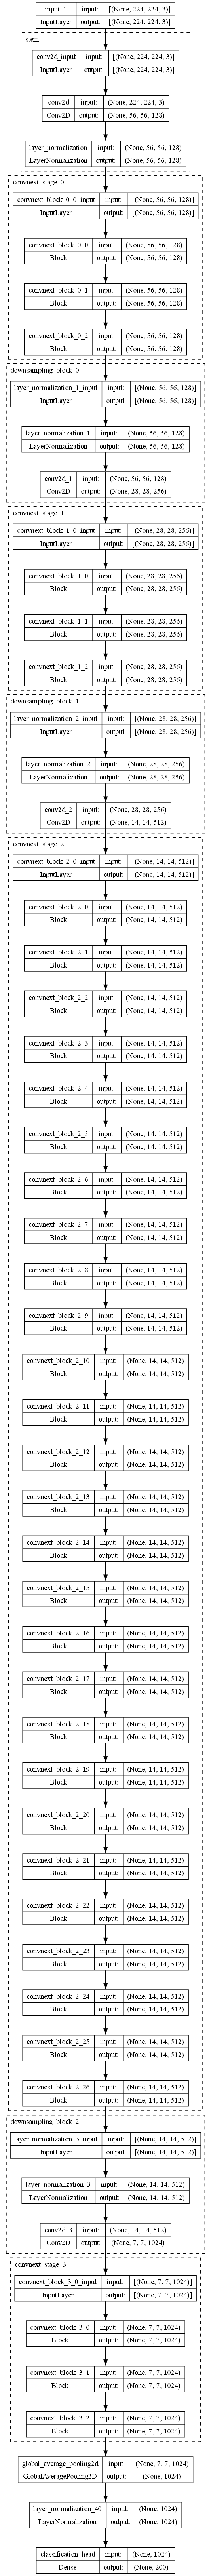

In [26]:
tf.keras.utils.plot_model(model, expand_nested=True, show_shapes=True)

In [27]:
import math
#https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/schedules/CosineDecay 
#https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/schedules/LearningRateSchedule for custom scheduling

class WarmupCosineDecay(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, initial_learning_rate, warmup_target, warmup_steps, decay_steps, alpha=0.0):
        self.initial_learning_rate = initial_learning_rate
        self.warmup_target = warmup_target
        self.warmup_steps = warmup_steps
        self.decay_steps = decay_steps
        self.alpha = alpha

    def __call__(self, step):
        warmup_lr = self.initial_learning_rate + (self.warmup_target - self.initial_learning_rate) * (step / self.warmup_steps)
        
        step_cosine = step - self.warmup_steps
        decay_steps_adjusted = self.decay_steps - self.warmup_steps
        cosine_decay = 0.5 * (1 + tf.cos(tf.constant(math.pi) * step_cosine / decay_steps_adjusted))
        decayed_lr = (1 - self.alpha) * cosine_decay + self.alpha
        decayed_lr = self.warmup_target * decayed_lr

        return tf.cond(
            step < self.warmup_steps,
            lambda: warmup_lr,
            lambda: decayed_lr
        )

In [28]:
lr_schedule = WarmupCosineDecay(
    initial_learning_rate=0,
    warmup_target=4e-3,
    warmup_steps=500,
    decay_steps=6825,
    alpha=0.0
)

In [29]:
AdamW_Experimental = tf.keras.optimizers.experimental.AdamW

optimizer = AdamW_Experimental(
    learning_rate=0.001,
    weight_decay=0.05,
    use_ema=True,          
    ema_momentum=0.999     
)

In [30]:
model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [31]:
REQUIRED_HEIGHT = 224
REQUIRED_WIDTH = 224

In [32]:
@tf.function
def resize_img(img, label):
    return tf.cast(tf.image.resize(img, (REQUIRED_HEIGHT, REQUIRED_WIDTH), method=tf.image.ResizeMethod.BICUBIC), tf.float16), label

In [33]:
train_ds = train_ds.map(resize_img, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.map(resize_img, num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=300,
)

In [1]:
## Suddenly, I dont have enough capacity to run the pretrain process (would be 30+ hour on an A100)

# Fine-tuning ConvNextLarge

In [34]:
del model
K.clear_session()

In [35]:
REQUIRED_HEIGHT = 224
REQUIRED_WIDTH = 224

In [38]:
@tf.function
def resize_img(img, label, scaled_version=False):
    img = tf.image.resize(img, (REQUIRED_HEIGHT, REQUIRED_WIDTH), method=tf.image.ResizeMethod.BICUBIC)

    if not scaled_version:
        img = tf.clip_by_value(img, 0.0, 255.0)
        img = tf.cast(img, tf.uint8)
    return img, label


In [39]:
train_ds_unscld = train_ds_unscld.map(lambda image, label: resize_img(image, label, scaled_version=False), num_parallel_calls=tf.data.AUTOTUNE)
val_ds_unscld = val_ds_unscld.map(lambda image, label: resize_img(image, label, scaled_version=False), num_parallel_calls=tf.data.AUTOTUNE)

In [48]:
base_model = tf.keras.applications.ConvNeXtXLarge(input_shape=(REQUIRED_HEIGHT, REQUIRED_WIDTH, 3),
                                               include_top=False,
                                               weights='imagenet',
                                               include_preprocessing=True,
                                                   )

 321454080/1393257616 [=====>........................] - ETA: 3:29

KeyboardInterrupt: 

In [ ]:
base_model.trainable = False

In [ ]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Input(shape=(REQUIRED_HEIGHT, REQUIRED_WIDTH, 3)))
model.add(base_model)
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(tf.keras.layers.Dropout(.25))
model.add(tf.keras.layers.Dense(100, activation='softmax'))

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
initial_epochs = 10

history_phase1 = model.fit(
    train_ds_unscld,
    validation_data=val_ds_unscld,
    epochs=initial_epochs
)

In [ ]:
base_model.trainable = True
unfreeze_last_n_layers = 50

for layer in base_model.layers[:-unfreeze_last_n_layers]:
    layer.trainable = False

In [ ]:
fine_tune_epochs = 5
initial_lr = 1e-4
fine_tune_optimizer = tf.keras.optimizers.Adam(learning_rate=initial_lr)

In [ ]:
model.compile(
    optimizer=fine_tune_optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history_phase2 = model.fit(
    train_ds_unscld,
    validation_data=val_ds_unscld,
    epochs=initial_epochs + fine_tune_epochs,
    initial_epoch=history_phase1.epoch[-1] + 1
)

In [ ]:
acc1 = history_phase1.history['accuracy']
val_acc1 = history_phase1.history['val_accuracy']
loss1 = history_phase1.history['loss']
val_loss1 = history_phase1.history['val_loss']

acc2 = history_phase2.history['accuracy']
val_acc2 = history_phase2.history['val_accuracy']
loss2 = history_phase2.history['loss']
val_loss2 = history_phase2.history['val_loss']

In [ ]:
acc = acc1 + acc2
val_acc = val_acc1 + val_acc2
loss = loss1 + loss2
val_loss = val_loss1 + val_loss2

phase1_end = len(acc1) 

In [ ]:
plt.figure(figsize=(8, 8))

plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.axvline(x=phase1_end - 1, color='gray', linestyle='--', label='Fine-tuning Start')

plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()), 1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.axvline(x=phase1_end - 1, color='gray', linestyle='--', label='Fine-tuning Start')

plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')

plt.tight_layout()
plt.show()

#### **Hint** : Using different Optimizer (SGD) or Learning Rate, different Augmentation (CutOut, MixUp) would enhance the Top-1 accuracy.

# Cross-validation on 3 StratifiedKFold